# Code for Project 2 Questions
### Chrissy Stoller

### SECTION 1. Statistical Test

In [2]:
import numpy as np
import scipy
import scipy.stats
import pandas

def mann_whitney_plus_means(turnstile_weather):
    # takes as input pandas DataFrame.
    # returns the mean of entries w/rain;
    # the mean of entries w/o rain;
    # the Mann-Whitney U-statistic; and
    # p-value comparing the number of entries w/rain and w/o rain.
    with_rain_entries = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 1]
    without_rain_entries = turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 0]
    
    with_rain_mean = np.mean(with_rain_entries)
    without_rain_mean = np.mean(without_rain_entries)
    
    U, p = scipy.stats.mannwhitneyu(with_rain_entries, without_rain_entries)
    return with_rain_mean, without_rain_mean, U, p

turnstile_weather_orig = pandas.read_csv('turnstile_data_master_with_weather.csv')

with_rain_mean, without_rain_mean, U, p = mann_whitney_plus_means(turnstile_weather_orig)
print 'with_rain_mean:', with_rain_mean
print 'without_rain_mean:', without_rain_mean
print 'U:', U
print 'p-value:', p

with_rain_mean: 1105.44637675
without_rain_mean: 1090.27878015
U: 1924409167.0
p-value: 0.0193096344138


### SECTION 2. Linear Regression

First: Manipulate dataset to include include day type information

Second: Run regression (OLS)

Third: Compute and examine residuals

In [3]:
from datetime import datetime

tw_enhanced = turnstile_weather_orig[['UNIT', 'DATEn', 'Hour', 
                                      'ENTRIESn_hourly', 'fog', 'rain', 
                                      'meanwindspdi', 'meantempi']]
tw_enhanced.is_copy = False

# add column DAYn with day of week [0,6]
tw_enhanced['DAYn'] = [datetime.strptime(x,'%Y-%m-%d').strftime('%w') 
                       for x in tw_enhanced['DATEn']]

def is_weekday(x):
    x = int(x)
    # if weekend
    if x == 0 or x == 6:
        return 0
    # if weekday
    else:
        return 1

#add column WEEKDAY with Weekend/Weekday
tw_enhanced['WEEKDAY'] = [is_weekday(x) for x in tw_enhanced['DAYn']]

def weekday_label(x):
    if x == 0:
        return 'Weekend'
    if x == 1:
        return 'Weekday'
    
#add column WEEKDAY_label
tw_enhanced['WEEKDAY_label'] = [weekday_label(x) for x in tw_enhanced['WEEKDAY']]

### tw_enhanced

DataFrame with the following columns:

'UNIT'..............Remote unit that collects turnstile information. 

    Can collect from multiple banks of turnstiles. Large subway stations can have more than one.

'DATEn'.............Date in “yyyy-mm-dd” (2011-05-21) format.

'Hour'..............Hour of the timestamp from TIMEn. Truncated.

'ENTRIESn_hourly'...Difference in ENTRIES from the previous REGULAR reading.

'fog'...............Indicator (0 or 1) if there was fog at the time & location.

'rain'..............Indicator (0 or 1) if rain occurred within the calendar day at the location.

'meanwindspdi'......Daily average windspeed in mph for the location.

'meantempi'.........Daily average temperature in F for the location.

'DAYn'..............Weekday as a decimal number: 0 is Sunday, 6 is Saturday.

'WEEKDAY'...........Indicator (0 or 1) if day is a weekday (M-F).

'WEEKDAY_label'.....Indicator ('Weekend' or 'Weekday').

In [4]:
import statsmodels.api as sm

def linear_regression(features, values):
    # features: input data points
    # values: output data points
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    params = results.params[1:]
    intercept = results.params[0]
    return intercept, params

def predictions(dataframe):
    # returns an array of predicted values using OLS linear regression
    # on selected features from dataframe
    features = dataframe[['rain', 'meantempi', 'meanwindspdi', 'WEEKDAY']]
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    dummy_hour = pandas.get_dummies(dataframe['Hour'], prefix ='hour')
    features = features.join(dummy_units)
    features = features.join(dummy_hour)
    values = dataframe['ENTRIESn_hourly']
    # Perform linear regression
    intercept, params = linear_regression(features, values)
    prediction_array = intercept + np.dot(features, params)
    return prediction_array, intercept, params

def compute_r_squared(data, predictions):
    ## data = list of actual data points
    ## predictions = list of predicted data points
    # error sum of squares
    SSE = np.sum((data - predictions)**2)
    # total corrected sum of squares
    SST = np.sum((data - np.mean(data))**2)
    r_squared = 1 - SSE / SST    
    return r_squared


predictions, intercept, params = predictions(tw_enhanced)
actual = tw_enhanced['ENTRIESn_hourly']
r_squared = compute_r_squared(actual, predictions)
print 'r_squared:', r_squared
print predictions
print 'Intercept:', intercept
print 'Params:'
print params

r_squared: 0.512925741491
[ 3264.99203165  2810.10748376  3912.57851572 ...,   129.71643823
   129.71643823   129.71643823]
Intercept: 1429.27002311
Params:
rain             -76.455984
meantempi         -6.556320
meanwindspdi      -7.827848
WEEKDAY          566.010128
unit_R001       2605.942797
unit_R002       -462.033583
unit_R003      -1544.098892
unit_R004      -1214.789612
unit_R005      -1201.446981
unit_R006      -1046.888368
unit_R007      -1391.796216
unit_R008      -1381.149312
unit_R009      -1390.650719
unit_R010       3447.462509
unit_R011       6386.806626
unit_R012       5820.443608
unit_R013        827.750254
unit_R014       2655.261958
unit_R015       1040.008784
unit_R016       -710.675399
unit_R017       2555.231539
unit_R018       4405.741766
unit_R019       1258.029541
unit_R020       4872.565374
unit_R021       2785.220876
unit_R022       6992.387352
unit_R023       4893.991024
unit_R024       1355.298580
unit_R025       3366.403265
unit_R027       1308.088243
   

[-39303.415886023213, 12958.479726608923]


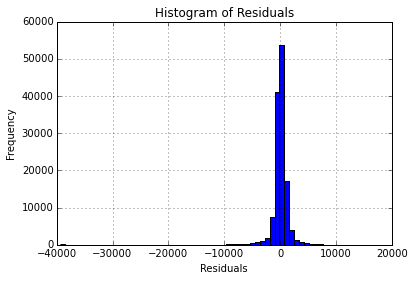

Mean hourly entries: 1095.34847784
[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 8, 7, 6, 4, 4, 9, 3, 8, 5, 6, 14, 16, 24, 19, 27, 20, 26, 41, 62, 68, 80, 73, 86, 119, 188, 227, 270, 395, 657, 1000, 1906, 7578, 41108, 53610, 17040, 3904, 1422, 703, 415, 281, 249, 102, 54, 24, 19, 14, 40, 4]


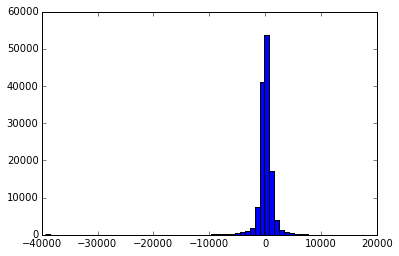

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

residuals = predictions - actual
print [min(residuals), max(residuals)]

fig_r = plt.figure()
residuals.hist(bins = 60)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

print 'Mean hourly entries:', np.mean(actual)
(n, bins, patches) = plt.hist(residuals, bins = 60)
print [ int(x) for x in n ]

### SECTION 3. Visualization

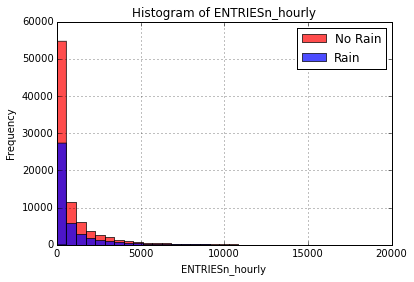

In [7]:
no_rain = tw_enhanced['ENTRIESn_hourly'][tw_enhanced['rain'] == 0][tw_enhanced['ENTRIESn_hourly'] <= 20000]
rain = tw_enhanced['ENTRIESn_hourly'][tw_enhanced['rain'] == 1][tw_enhanced['ENTRIESn_hourly'] <= 20000]

fig = plt.figure()
no_rain.hist(bins=35, alpha=0.7, color='red', label='No Rain')
rain.hist(bins=35, alpha=0.7, color='blue', label='Rain')

plt.legend()
plt.title('Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.show()

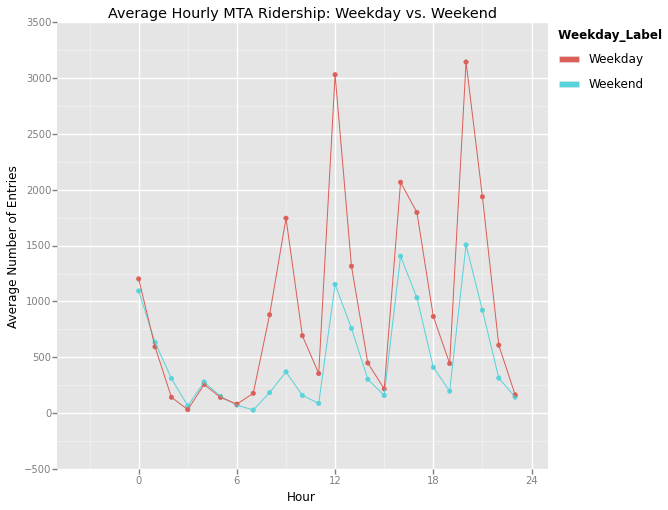

<ggplot: (29214117)>

In [11]:
import pandasql
from ggplot import *

q1 = """
    SELECT
    Hour, avg(ENTRIESn_hourly), WEEKDAY_label
    FROM
    tw_enhanced
    GROUP BY
    Hour, WEEKDAY_label
    """

avg_hourly_entries_daytype = pandasql.sqldf(q1, locals())

ggplot(avg_hourly_entries_daytype, aes(x='Hour', y='avg(ENTRIESn_hourly)', color='WEEKDAY_label')) + \
    geom_point() + geom_line() + \
    xlab('Hour') + ylab('Average Number of Entries') + \
    scale_x_continuous(breaks=[0, 6, 12, 18, 24]) + \
    ggtitle('Average Hourly MTA Ridership: Weekday vs. Weekend')

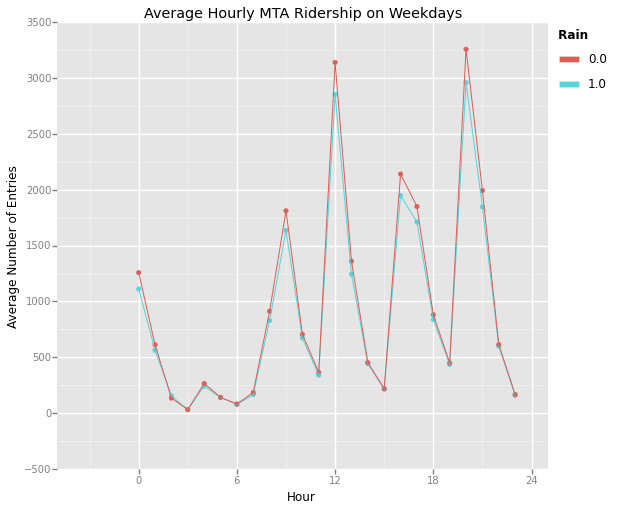

<ggplot: (36601916)>

In [12]:
q2 = """
    SELECT
    Hour, avg(ENTRIESn_hourly), rain, WEEKDAY
    FROM
    tw_enhanced
    WHERE
    WEEKDAY == 1
    GROUP BY
    Hour, rain
    """

avg_hourly_entries_rain = pandasql.sqldf(q2, locals())

ggplot(avg_hourly_entries_rain, aes(x='Hour', y='avg(ENTRIESn_hourly)', color='rain')) + \
    geom_point() + geom_line() + \
    xlab('Hour') + ylab('Average Number of Entries') + \
    scale_x_continuous(breaks=[0, 6, 12, 18, 24]) + \
    ggtitle('Average Hourly MTA Ridership on Weekdays')

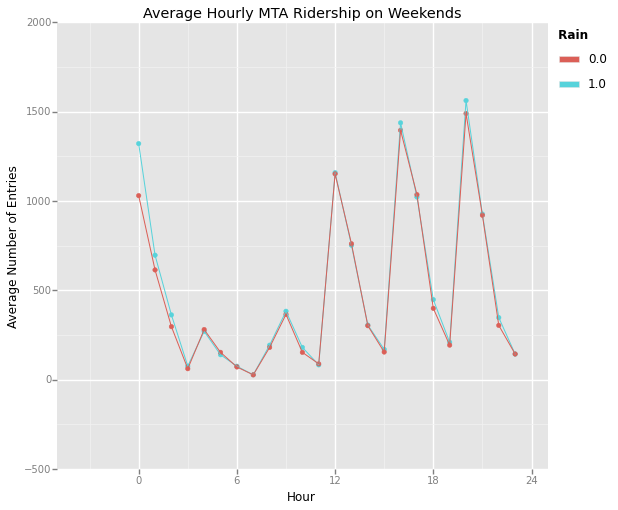

<ggplot: (36679761)>

In [13]:
q3 = """
    SELECT
    Hour, avg(ENTRIESn_hourly), rain, WEEKDAY
    FROM
    tw_enhanced
    WHERE
    WEEKDAY == 0
    GROUP BY
    Hour, rain
    """

avg_hourly_entries_rain = pandasql.sqldf(q3, locals())

ggplot(avg_hourly_entries_rain, aes(x='Hour', y='avg(ENTRIESn_hourly)', color='rain')) + \
    geom_point() + geom_line() + \
    xlab('Hour') + ylab('Average Number of Entries') + \
    scale_x_continuous(breaks=[0, 6, 12, 18, 24]) + \
    ggtitle('Average Hourly MTA Ridership on Weekends')